# Phase 04: Modeling

## Import các thư viện cần thiết

In [99]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns


import concurrent.futures
import pickle


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
)

from sklearn.svm import SVC

# Chuẩn bị dữ liệu
from sklearn.preprocessing import LabelEncoder
# Xây dựng mô hình
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import sklearn
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")

## Tiền xử lý dữ liệu

### Chuẩn bị các dữ liệu cần thiết

In [100]:
match_overview_df = pd.read_csv('./data/clean_data/match_overview.csv', delimiter='\t')
team_profile_df = pd.read_csv('./data/clean_data/team_profile.csv', delimiter=',')
match_statistics_df = pd.read_csv('./data/clean_data/match_statistics.csv', delimiter='\t')

Đầu tiên, ta cần kết hợp các dữ liệu từ Team Profile vào thông tin của các trận đấu.

In [101]:
team_profile_selected = team_profile_df[['Season', 'Club', 'Squad', 'Average age', 'Foreigners', 'Total market value']]

df_home = pd.merge(match_overview_df, team_profile_selected,
                   left_on=['Season', 'Home Team'], right_on=['Season', 'Club'],
                   how='left', suffixes=('', '_Home'))

df_combined = pd.merge(df_home, team_profile_selected,
                       left_on=['Season', 'Away Team'], right_on=['Season', 'Club'],
                       how='left', suffixes=('_Home', '_Away'))


Sau đó, ta nhận ra một vài cột bị trùng lặp thông tin, nên ta tiến hành xóa bỏ những cột đó ra khỏi dữ liệu.

In [102]:

df_combined.drop(columns=['Club_Home', 'Club_Away'], inplace=True)


Sau đó, ta tiến hành kết hợp DataFrame vừa tạo được ở trên vào DataFrame Match_overview để phục vụ cho việc xây dựng mô hình của bài toán

In [103]:
df_combined = pd.merge(df_combined, match_statistics_df, left_on='Match ID', right_on='match_id', how='left')
df_combined.drop(['match_id'], axis=1, inplace=True)

Một số thông tin không có giá trị dự đoán hoặc không mang nhiều ý nghĩa như Match_ID, ta cũng sẽ loại bỏ. Và thông tin Date bị trùng với Season, nên ta xóa Date

Bên cạnh đó, sau khi xem xét lại trong Giai đoạn 3: Trực quan hóa dữ liệu, chúng ta nhận thấy rằng các thuộc tính như **Squad** và **Foreigners** không có tác động đáng kể đến kết quả xếp hạng hoặc chiến thắng của đội bóng. Vì vậy, các thuộc tính này cũng sẽ được loại bỏ.

Ngoài ra, cột **Fulltime Score** chỉ có ý nghĩa khi trận đấu đã kết thúc. Tuy nhiên, chúng ta quan tâm đến kết quả của trận đấu trước khi trận đấu đó kết thúc. Do đó, cột này cũng sẽ được xóa khỏi dữ liệu.

In [104]:
df_combined.drop(columns=['Match ID', 'Date', 'Fulltime Score', 'Squad_Home', 'Squad_Away', 'Foreigners_Home', 'Foreigners_Away'], inplace=True)
df_combined.head(3)

,Season,Home Team,Away Team,Home Lineup,Away Lineup,Winner,Average age_Home,Total market value_Home,Average age_Away,Total market value_Away,...,home_offsides,home_fouls,away_total_shots,away_shots_saved,away_corners,away_free_kicks,away_offsides,away_fouls,home_cards,away_cards
0,18/19,Newcastle United,Tottenham Hotspur,4-4-1-1,4-3-2-1,Tottenham Hotspur,26.6,0.136488,26.0,0.601123,...,11,1,6,1,5,12,12,0,2,2
1,18/19,Fulham FC,Crystal Palace,4-3-3,4-4-2,Crystal Palace,26.2,0.143309,26.9,0.167999,...,8,2,9,6,5,10,11,3,1,2
2,18/19,AFC Bournemouth,Cardiff City,4-4-2,4-1-4-1,AFC Bournemouth,26.2,0.182919,27.8,0.042950,...,12,0,1,0,4,12,8,2,1,1


Ngoài ra, để dễ trực quan, thì ta sẽ di chuyển đặc trưng **Winner** ra cuối cùng thay vì cột đó nằm ở vị trí giữa bảng.

In [105]:

cols = df_combined.columns.tolist()

cols.append(cols.pop(cols.index('Winner')))

df_combined = df_combined[cols]

df_combined.head(3)

,Season,Home Team,Away Team,Home Lineup,Away Lineup,Average age_Home,Total market value_Home,Average age_Away,Total market value_Away,home_total_shots,...,home_fouls,away_total_shots,away_shots_saved,away_corners,away_free_kicks,away_offsides,away_fouls,home_cards,away_cards,Winner
0,18/19,Newcastle United,Tottenham Hotspur,4-4-1-1,4-3-2-1,26.6,0.136488,26.0,0.601123,2,...,1,6,1,5,12,12,0,2,2,Tottenham Hotspur
1,18/19,Fulham FC,Crystal Palace,4-3-3,4-4-2,26.2,0.143309,26.9,0.167999,6,...,2,9,6,5,10,11,3,1,2,Crystal Palace
2,18/19,AFC Bournemouth,Cardiff City,4-4-2,4-1-4-1,26.2,0.182919,27.8,0.042950,3,...,0,1,0,4,12,8,2,1,1,AFC Bournemouth


Chúng ta sẽ kiểm tra lại, sau các thao tác nãy giờ thì liệu có thiếu dữ liệu nào không?

In [106]:
null_rows = df_combined[df_combined.isnull().any(axis=1)]
print(null_rows)

Empty DataFrame
Columns: [Season, Home Team, Away Team, Home Lineup, Away Lineup, Average age_Home, Total market value_Home, Average age_Away, Total market value_Away, home_total_shots, home_shots_saved, home_corners, home_free_kicks, home_offsides, home_fouls, away_total_shots, away_shots_saved, away_corners, away_free_kicks, away_offsides, away_fouls, home_cards, away_cards, Winner]
Index: []

[0 rows x 24 columns]


Để mô hình chạy được, ta cần mã hóa các dạng dữ liệu Categorical sang dạng Numerical

Lý do: Mô hình chỉ hoạt động hiệu quả khi các cột đưa vào là dạng số.

Trước hết, ta sẽ mã hóa tên các đội bóng theo thứ tự từ 0 đến 34.

In [107]:
unique_teams = df_combined['Home Team'].unique()
team_encoder = {team: idx for idx, team in enumerate(unique_teams)}

team_encoder['Draw'] = 34

df_combined['Home Team'] = df_combined['Home Team'].map(team_encoder)
df_combined['Away Team'] = df_combined['Away Team'].map(team_encoder)

df_combined['Winner'] = df_combined['Winner'].apply(lambda x: team_encoder['Draw'] if x == 'Draw' else team_encoder[x])

df_combined

,Season,Home Team,Away Team,Home Lineup,Away Lineup,Average age_Home,Total market value_Home,Average age_Away,Total market value_Away,home_total_shots,...,home_fouls,away_total_shots,away_shots_saved,away_corners,away_free_kicks,away_offsides,away_fouls,home_cards,away_cards,Winner
0,18/19,0,12,4-4-1-1,4-3-2-1,26.6,0.136488,26.0,0.601123,2,...,1,6,1,5,12,12,0,2,2,12
1,18/19,1,17,4-3-3,4-4-2,26.2,0.143309,26.9,0.167999,6,...,2,9,6,5,10,11,3,1,2,17
2,18/19,2,9,4-4-2,4-1-4-1,26.2,0.182919,27.8,0.042950,3,...,0,1,0,4,12,8,2,1,1,2
3,18/19,3,10,3-4-3,4-2-3-1,24.5,0.177875,26.6,0.338591,4,...,2,5,2,6,9,7,3,0,3,34
4,18/19,4,11,4-1-4-1,4-4-2,25.9,0.529362,26.9,0.271093,6,...,4,4,4,5,15,7,2,2,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474,23/24,27,12,5-3-2,4-2-3-1,24.7,0.070979,25.6,0.558421,6,...,6,18,1,6,11,9,0,2,0,12
3475,23/24,10,27,4-4-1-1,3-5-2,26.8,0.241003,24.7,0.070979,15,...,3,13,6,6,6,11,0,1,2,10
3476,23/24,33,1,3-4-3,4-2-3-1,25.7,0.062773,26.9,0.235745,15,...,8,15,4,4,14,20,1,5,4,1
3477,23/24,7,10,4-3-3,4-4-1-1,24.6,0.815269,26.8,0.241003,26,...,1,5,4,1,8,11,4,4,3,7


Thông tin được mã hóa như sau

| Team Name                     | Label |
|-------------------------------|-------|
| Newcastle United              | 0     |
| Fulham FC                     | 1     |
| AFC Bournemouth               | 2     |
| Wolverhampton Wanderers       | 3     |
| Manchester United             | 4     |
| Huddersfield Town             | 5     |
| Watford FC                    | 6     |
| Arsenal FC                    | 7     |
| Liverpool FC                  | 8     |
| Cardiff City                  | 9     |
| Everton FC                    | 10    |
| Leicester City                | 11    |
| Tottenham Hotspur             | 12    |
| Burnley FC                    | 13    |
| West Ham United               | 14    |
| Manchester City               | 15    |
| Brighton & Hove Albion        | 16    |
| Crystal Palace                | 17    |
| Chelsea FC                    | 18    |
| Southampton FC                | 19    |
| Queens Park Rangers           | 20    |
| Stoke City                    | 21    |
| West Bromwich Albion          | 22    |
| Aston Villa                   | 23    |
| Swansea City                  | 24    |
| Hull City                     | 25    |
| Sunderland AFC                | 26    |
| Sheffield United              | 27    |
| Leeds United                  | 28    |
| Brentford FC                  | 29    |
| Norwich City                  | 30    |
| Middlesbrough FC              | 31    |
| Nottingham Forest             | 32    |
| Luton Town                    | 33    |
| Draw                          | 34    |

Ngoài ra, ta cũng cần mã hóa Đội hình xuất phát của các đội bóng

In [108]:
all_lineups = pd.concat([df_combined['Home Lineup'], df_combined['Away Lineup']]).unique()

lineup_encoder = {lineup: idx for idx, lineup in enumerate(all_lineups)}
df_combined['Home Lineup'] = df_combined['Home Lineup'].map(lineup_encoder)
df_combined['Away Lineup'] = df_combined['Away Lineup'].map(lineup_encoder)

df_combined

,Season,Home Team,Away Team,Home Lineup,Away Lineup,Average age_Home,Total market value_Home,Average age_Away,Total market value_Away,home_total_shots,...,home_fouls,away_total_shots,away_shots_saved,away_corners,away_free_kicks,away_offsides,away_fouls,home_cards,away_cards,Winner
0,18/19,0,12,0,13,26.6,0.136488,26.0,0.601123,2,...,1,6,1,5,12,12,0,2,2,12
1,18/19,1,17,1,2,26.2,0.143309,26.9,0.167999,6,...,2,9,6,5,10,11,3,1,2,17
2,18/19,2,9,2,4,26.2,0.182919,27.8,0.042950,3,...,0,1,0,4,12,8,2,1,1,2
3,18/19,3,10,3,6,24.5,0.177875,26.6,0.338591,4,...,2,5,2,6,9,7,3,0,3,34
4,18/19,4,11,4,2,25.9,0.529362,26.9,0.271093,6,...,4,4,4,5,15,7,2,2,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474,23/24,27,12,11,6,24.7,0.070979,25.6,0.558421,6,...,6,18,1,6,11,9,0,2,0,12
3475,23/24,10,27,0,5,26.8,0.241003,24.7,0.070979,15,...,3,13,6,6,6,11,0,1,2,10
3476,23/24,33,1,3,6,25.7,0.062773,26.9,0.235745,15,...,8,15,4,4,14,20,1,5,4,1
3477,23/24,7,10,1,0,24.6,0.815269,26.8,0.241003,26,...,1,5,4,1,8,11,4,4,3,7


| Formation    | Label |
|--------------|-------|
| 4-4-1-1      | 0     |
| 4-3-3        | 1     |
| 4-4-2        | 2     |
| 3-4-3        | 3     |
| 4-1-4-1      | 4     |
| 3-5-2        | 5     |
| 4-2-3-1      | 6     |
| 5-4-1        | 7     |
| 3-4-2-1      | 8     |
| 4-3-1-2      | 9     |
| 4-1-3-2      | 10    |
| 5-3-2        | 11    |
| 3-4-1-2      | 12    |
| 4-3-2-1      | 13    |
| 4-5-1        | 14    |
| 3-1-4-2      | 15    |
| 3-3-3-1      | 16    |

Mã hóa lại cột Season

In [109]:
all_season = pd.concat([df_combined['Season']]).unique()

season_encoder = {lineup: idx for idx, lineup in enumerate(all_season)}
df_combined['Season'] = df_combined['Season'].map(season_encoder)
df_combined

,Season,Home Team,Away Team,Home Lineup,Away Lineup,Average age_Home,Total market value_Home,Average age_Away,Total market value_Away,home_total_shots,...,home_fouls,away_total_shots,away_shots_saved,away_corners,away_free_kicks,away_offsides,away_fouls,home_cards,away_cards,Winner
0,0,0,12,0,13,26.6,0.136488,26.0,0.601123,2,...,1,6,1,5,12,12,0,2,2,12
1,0,1,17,1,2,26.2,0.143309,26.9,0.167999,6,...,2,9,6,5,10,11,3,1,2,17
2,0,2,9,2,4,26.2,0.182919,27.8,0.042950,3,...,0,1,0,4,12,8,2,1,1,2
3,0,3,10,3,6,24.5,0.177875,26.6,0.338591,4,...,2,5,2,6,9,7,3,0,3,34
4,0,4,11,4,2,25.9,0.529362,26.9,0.271093,6,...,4,4,4,5,15,7,2,2,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474,9,27,12,11,6,24.7,0.070979,25.6,0.558421,6,...,6,18,1,6,11,9,0,2,0,12
3475,9,10,27,0,5,26.8,0.241003,24.7,0.070979,15,...,3,13,6,6,6,11,0,1,2,10
3476,9,33,1,3,6,25.7,0.062773,26.9,0.235745,15,...,8,15,4,4,14,20,1,5,4,1
3477,9,7,10,1,0,24.6,0.815269,26.8,0.241003,26,...,1,5,4,1,8,11,4,4,3,7


Ngoài ra, cột target chỉnh thành 1 nếu đội nhà thắng, 0 nếu đội nhà không thắng

In [110]:
df_combined.loc[df_combined['Winner'] == df_combined['Home Team'], 'Winner'] = 1

df_combined.loc[df_combined['Winner'] == df_combined['Away Team'], 'Winner'] = 0

df_combined.loc[
    (df_combined['Winner'] != 1) & (df_combined['Winner'] != 0),
    'Winner'] = 0
df_combined

,Season,Home Team,Away Team,Home Lineup,Away Lineup,Average age_Home,Total market value_Home,Average age_Away,Total market value_Away,home_total_shots,...,home_fouls,away_total_shots,away_shots_saved,away_corners,away_free_kicks,away_offsides,away_fouls,home_cards,away_cards,Winner
0,0,0,12,0,13,26.6,0.136488,26.0,0.601123,2,...,1,6,1,5,12,12,0,2,2,0
1,0,1,17,1,2,26.2,0.143309,26.9,0.167999,6,...,2,9,6,5,10,11,3,1,2,0
2,0,2,9,2,4,26.2,0.182919,27.8,0.042950,3,...,0,1,0,4,12,8,2,1,1,1
3,0,3,10,3,6,24.5,0.177875,26.6,0.338591,4,...,2,5,2,6,9,7,3,0,3,0
4,0,4,11,4,2,25.9,0.529362,26.9,0.271093,6,...,4,4,4,5,15,7,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474,9,27,12,11,6,24.7,0.070979,25.6,0.558421,6,...,6,18,1,6,11,9,0,2,0,0
3475,9,10,27,0,5,26.8,0.241003,24.7,0.070979,15,...,3,13,6,6,6,11,0,1,2,1
3476,9,33,1,3,6,25.7,0.062773,26.9,0.235745,15,...,8,15,4,4,14,20,1,5,4,0
3477,9,7,10,1,0,24.6,0.815269,26.8,0.241003,26,...,1,5,4,1,8,11,4,4,3,1


Trong bảng dữ liệu trên, ta nhận thấy **Total market value** có giá trị lớn hơn nhiều so với các đặc trưng còn lại, điều này có thể gây ra một số vấn đề trong quá trình phân tích dữ liệu và xây dựng mô hình học máy.

Ví dụ như, các thuật toán **SVM, kNN,...** nhạy cảm với một vài đặc trưng có phạm vi giá trị khác nhau. Nên ta cần dùng phương pháp chuẩn hóa dữ liệu đối với tất cả các đặc trưng là dữ liệu số về cùng một thang đo 0-1, phù hợp với khoảng giá trị của nhãn. Trừ các trường hợp các giá trị số mang ý nghĩa là Category

In [111]:
columns_to_scale = ['Average age_Home', 'Average age_Away', 'home_total_shots', 'home_corners','away_total_shots', 'away_corners', 'home_cards', 'away_cards', 'home_shots_saved', 'away_shots_saved', 'home_cards', 'away_cards']
scaler = MinMaxScaler()
df_combined[columns_to_scale] = scaler.fit_transform(df_combined[columns_to_scale])

Chúng ta sẽ kiểm tra lại dữ liệu được phân bổ

In [112]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Season                   3479 non-null   int64  
 1   Home Team                3479 non-null   int64  
 2   Away Team                3479 non-null   int64  
 3   Home Lineup              3479 non-null   int64  
 4   Away Lineup              3479 non-null   int64  
 5   Average age_Home         3479 non-null   float64
 6   Total market value_Home  3479 non-null   float64
 7   Average age_Away         3479 non-null   float64
 8   Total market value_Away  3479 non-null   float64
 9   home_total_shots         3479 non-null   float64
 10  home_shots_saved         3479 non-null   float64
 11  home_corners             3479 non-null   float64
 12  home_free_kicks          3479 non-null   int64  
 13  home_offsides            3479 non-null   int64  
 14  home_fouls              

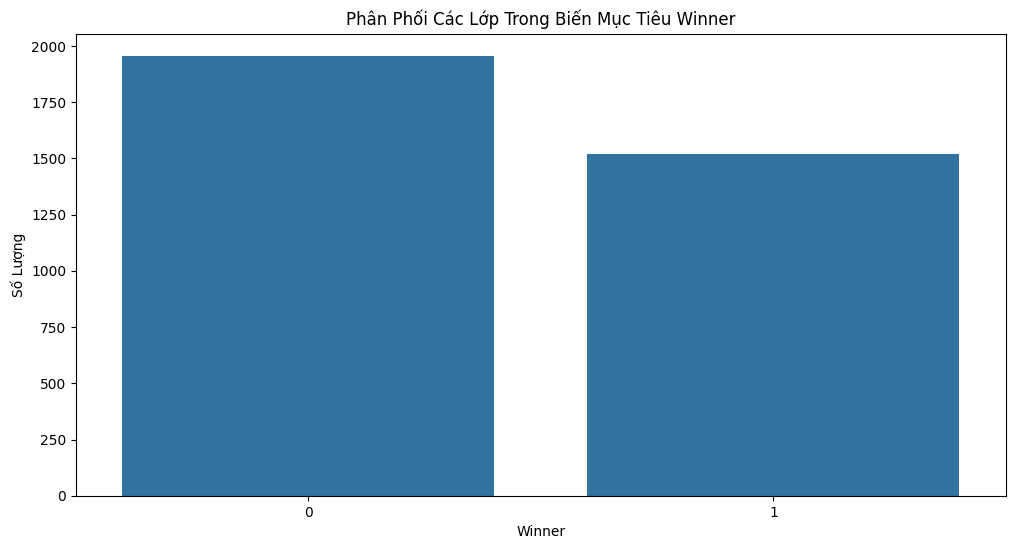

Winner
0    1957
1    1522
Name: count, dtype: int64


In [113]:
# Kiểm tra phân phối các lớp
plt.figure(figsize=(12,6))
sns.countplot(x='Winner', data=df_combined)
plt.title('Phân Phối Các Lớp Trong Biến Mục Tiêu Winner')
plt.xlabel('Winner')
plt.ylabel('Số Lượng')
plt.xticks()
plt.show()

# In số lượng mẫu mỗi lớp
print(df_combined['Winner'].value_counts())

### Nhận xét

Ta thấy, số lượng mẫu có nhãn là 1 và 0 phân bố khá đồng đều, không lệch quá nhiều về bên nào mặc dù bên 0 cao hơn 1 tí. Điều này cho thấy, ta sẽ chấp nhận kết quả nếu accuracy nếu đạt trên 65%

## Kiểm tra trích xuất đặc trưng

- Trong một bộ dữ liệu, không phải tất cả các cột đều có ảnh hưởng đáng kể đến biến mục tiêu. Do đó, cần áp dụng các phương pháp thống kê để đánh giá mức độ tác động của từng cột đối với biến mục tiêu.
- Việc trích xuất đặc trưng mang lại những lợi ích quan trọng như: giảm độ phức tạp của mô hình, cải thiện hiệu suất dự đoán và rút ngắn thời gian huấn luyện.
- Đối với đồ án mà nhóm thực hiện, dữ liệu bao gồm hai loại biến: biến số và biến phân loại. Do đã mã hóa các biến phân loại trước đó rồi, ta chỉ cần áp dụng hệ số Pearson. Dựa trên kết quả phân tích p-value, nhóm chúng em đã lựa chọn các đặc trưng quan trọng nhất để đưa vào mô hình.

In [114]:
numerical_features = [
    'Home Lineup', 'Away Lineup',
    'Average age_Home', 'Total market value_Home',
    'Average age_Away', 'Total market value_Away',
    'home_total_shots', 'home_corners', 'home_shots_saved', 'away_shots_saved',
    'away_total_shots', 'away_corners',
    'home_cards', 'away_cards'
]


In [115]:
affect_numerical_columns = []

for column in numerical_features:
    try:
        correlation, p_value = pearsonr(df_combined[column], df_combined['Winner'])
        print(f'\nPearson Correlation for {column}:\n')
        print(f'Correlation: {correlation}, P-value: {p_value}')

        if p_value < 0.05:
            print(f'{column} có ảnh hưởng đến Winner')
            affect_numerical_columns.append(column)
        else:
            print(f'{column} không có ảnh hưởng đến Winner')
    except Exception as e:
        print(f'Error processing column {column}: {e}')


Pearson Correlation for Home Lineup:

Correlation: -0.026605099234764975, P-value: 0.11665641198493214
Home Lineup không có ảnh hưởng đến Winner

Pearson Correlation for Away Lineup:

Correlation: 0.0005368516442929738, P-value: 0.9747481628439765
Away Lineup không có ảnh hưởng đến Winner

Pearson Correlation for Average age_Home:

Correlation: -0.0983080238144838, P-value: 6.228573042924256e-09
Average age_Home có ảnh hưởng đến Winner

Pearson Correlation for Total market value_Home:

Correlation: 0.2533474058259593, P-value: 4.361958644097556e-52
Total market value_Home có ảnh hưởng đến Winner

Pearson Correlation for Average age_Away:

Correlation: 0.08211900742059394, P-value: 1.234105694197127e-06
Average age_Away có ảnh hưởng đến Winner

Pearson Correlation for Total market value_Away:

Correlation: -0.2099499522484954, P-value: 5.89100696476079e-36
Total market value_Away có ảnh hưởng đến Winner

Pearson Correlation for home_total_shots:

Correlation: 0.16205643678011314, P-val

Loại bỏ các feature nào không mang giá trị ảnh hưởng đến côt Target

In [116]:
df_combined.drop(['Home Lineup', 'Away Lineup', 'away_cards'], axis=1, inplace=True)

Câu hỏi:
1. Chọn bao nhiêu mô hình để thực hiện?  
2. Chia tập train test như thế nào?  
3. Áp dụng hyperparams turning như thế nào?
4. KFold để làm gì?  
5. Lựa chọn những tham số nào để đánh giá mô hình?  
6. Trước khi chạy mô hình ta có thể dự đoán mô hình nào cho hiệu suất cao không? Tại sao có thể dự đoán được?

1. Số Lượng Mô Hình Được Chọn Để Thực Hiện:    

- Các mô hình được chọn để thực hiện, bao gồm: Random Forest, Gradient Boosting, XGBoost, LightGBM, Extra Trees, AdaBoost, Linear Regression, Lasso Regression, Decision Tree, và Support Vector Regression.

2. Chia Tập Train và Test:  

- Dữ liệu được chia thành hai phần: tập huấn luyện (train) và tập kiểm tra (test), với tỷ lệ là 80% dữ liệu cho tập huấn luyện và 20% dữ liệu cho tập kiểm tra.

3. Áp Dụng Hyperparameter Tuning:  

- Hyperparameter tuning được thực hiện thông qua GridSearchCV, với mỗi mô hình có một tập tham số cụ thể (được liệt kê trong param_grids). GridSearchCV sẽ tìm kiếm qua không gian tham số này để tìm ra bộ tham số tốt nhất cho mỗi mô hình dựa trên tiêu chí đánh giá (scoring), ở đây là 'neg_mean_squared_error'.

4. Mục Đích của K-Fold Cross Validation:  Do dữ liệu không quá lớn nên nhóm không chọn **3-Way Data Split**

- Phương pháp này chia dữ liệu thành 5 phần, mỗi lần lấy 4 phần để huấn luyện mô hình và 1 phần để kiểm tra, nhằm đảm bảo mô hình được kiểm tra trên toàn bộ dữ liệu và giảm thiểu bias và variance.

5. Các Tham Số Được Chọn Để Đánh Giá Mô Hình:  

- Các tham số được sử dụng để đánh giá mô hình bao gồm: Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), và R-squared (R2).

6. Dự Đoán Hiệu Suất Mô Hình Trước Khi Chạy:  

- Dựa trên kiến thức về các mô hình, chúng em kỳ vọng rằng các mô hình như Random Forest, Gradient Boosting, XGBoost, LightGBM, và Extra Trees thường xử lý tốt với dữ liệu phức tạp và không tuyến tính. Còn những mô hình còn lại dựa hồi quy một đường thẳng nên khó có thể dữ đoán chính xác cao được



– Logistic Regression;

– K-Nearest Neighbors;

– Support Vector Machine;

– Na¨ıve Bayes;

– Random Forest;

– Four-layer Artificial Neural Network.

## Nhắc lại bài toán được đặt ra ban đầu

Làm sao để một đội có khả năng thắng hay không (ở đây ta sẽ quan tâm đội bóng chủ nhà) khi trận đấu xảy ra, dựa trên các tiêu chí Average age, Total Market Value

## Thực hiện Mô hình

Đầu tiên, ta cần xác định cột mục tiêu của bài toán là Winner, các cột biến phụ thuộc là các cột còn lại

### Chia dữ liệu theo K-Fold Cross Validation

- Mục đích:
    - Huấn luyện và đánh giá độc lập: Tập huấn luyện được sử dụng để huấn luyện mô hình. Tập kiểm tra được sử dụng để đánh giá hiệu suất tổng quát của mô hình. Dữ liệu này không được sử dụng trong quá trình huấn luyện để đảm bảo mô hình có khả năng tổng quát hóa với dữ liệu mới, đảm bảo tính khách quan.
    - Kiểm tra: Tập validation được sử dụng để tìm ra mô hình tốt nhất với những siêu tham số khác nhau.
    - Tránh overfitting: Nếu không chia dữ liệu mà sử dụng toàn bộ dữ liệu để huấn luyện, mô hình có thể học "quá khớp" (overfit) dữ liệu huấn luyện mà không tổng quát hóa được cho dữ liệu mới. Việc có tập kiểm tra giúp đánh giá xem mô hình có đang học từ dữ liệu một cách tổng quát hay chỉ học "nhớ" dữ liệu huấn luyện không.
    - Đánh giá và cải thiện mô hình: Thông qua việc đánh giá trên tập kiểm tra, chúng ta có thể đánh giá hiệu suất của mô hình và cải thiện nó thông qua việc điều chỉnh các tham số hoặc phương pháp huấn luyện.
- Kích thước mỗi tập như sau:
    - Training = Sizeof(Season < 9) ~ 3100 mẫu dữ liệu
    - Test = Sizeof(Season >= 9) ~ 360 mẫu dữ liệu

Lý do chia mẫu như vậy là do đặc thù của bài toán, mô hình chỉ có thể dự đoán được kết quả chiến thắng cho các đội bóng chủ nhà trong gần nhất là 1 mùa giải trong tương lai, không thể dự đoán trong 2 mùa liên tiếp (Điều này được đánh giá là rất khó để thực hiện trong khi hiện nay chưa có một mô hình nào có thể cho độ chính xác quá cao)

In [117]:
train_data = df_combined[df_combined['Season'] < 9]
test_data = df_combined[df_combined['Season'] >= 9]

X_train = train_data.drop(['Winner'], axis=1)
y_train = train_data['Winner']

X_test = test_data.drop(['Winner'], axis=1)
y_test = test_data['Winner']

Do có một yếu tố là Season mang nặng giá trị về thời gian, nên sức mạnh của một đội bóng qua một thời gian cũng thay đổi. Vì vậy, ta sẽ không Shuffle (trộn) khi sử dụng K-Fold Cross Validation

In [118]:
# Sử dụng KFold không shuffle trên tập train
kf = KFold(n_splits=3, shuffle=False)
print("Distribution in y_train:")
print(y_train.value_counts())

print("\nDistribution in y_test:")
print(y_test.value_counts())

Distribution in y_train:
Winner
0    1756
1    1366
Name: count, dtype: int64

Distribution in y_test:
Winner
0    201
1    156
Name: count, dtype: int64


### Định nghĩa các mô hình cần huấn luyện

Do bài toán được đặt ra là bài toán thuộc về loại Binary Classification, và để tối ưu được độ chính xác thì ta chỉ cần khảo sát các mô hình ML dùng để phân loại. Các thuật toán được liệt kê dưới đây

    1. Mô hình SVM
    2. Mô hình XGBoost
    3. Mô hình MLP
    4. Mô hình RandomForest

Tương ứng tại mỗi mô hình, ta cũng sẽ sử dụng GridSearchCV để tìm ra được tập tham số tốt nhất

#### 1. Mô Hình Support Vector Machine (SVM):

Mô hình SVM là một thuật toán học có giám sát được sử dụng chủ yếu cho các vấn đề phân loại và hồi quy. SVM tập trung vào việc tìm một đường ranh giới phân chia tốt nhất giữa các lớp dữ liệu.

Cách hoạt động
1. **Tìm đường ranh giới:** Trong SVM, mục tiêu đầu tiên là xác định một đường ranh giới (hay còn gọi là hyperplane) để phân chia các điểm dữ liệu thành các lớp khác nhau. Với dữ liệu có nhiều đặc trưng như bài toán hiện tại, SVM tìm kiếm một siêu phẳng trong không gian đặc trưng để phân chia các lớp một cách tối ưu.

2. **Tối ưu hóa ranh giới:** Sau khi xác định được đường ranh giới, SVM tiếp tục tối ưu hóa nó để đảm bảo hiệu quả phân loại cao nhất. SVM chọn siêu phẳng sao cho khoảng cách từ các điểm dữ liệu gần nhất (gọi là hỗ trợ vector) đến siêu phẳng là lớn nhất có thể. Điều này giúp tăng khả năng tổng quát hóa của mô hình và giảm nguy cơ overfitting.

3. **Kernel Trick:** Bằng cách áp dụng các hàm kernel (như RBF, polynomial), SVM có thể ánh xạ dữ liệu từ không gian đặc trưng gốc vào một không gian đặc trưng cao hơn, nơi dữ liệu có thể được phân loại một cách tuyến tính.

Định nghĩa các tham số để tìm kiếm

In [119]:
param_grid = {
    'C': [0.1, 1, 10],         
    'kernel': ['linear'],  
    'gamma': ['scale', 'auto']            
}

In [120]:
best_svm_model = SVC(random_state=42,probability=True)

grid_search = GridSearchCV(
    estimator=best_svm_model,
    param_grid=param_grid,
    cv=kf,                      # Sử dụng đối tượng cross-validator đã có (kf)
    scoring='accuracy',         # Đánh giá bằng độ chính xác
)


grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=SVC(probability=True, random_state=42),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear']},
             scoring='accuracy')

Tham số tốt nhất tìm được

In [121]:
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-Validation Accuracy: 0.7110757038350698


**Lưu lại mô hình với tham số tốt nhất**

In [122]:
best_svm_model = grid_search.best_estimator_

Test Accuracy: 0.6946778711484594


#### Nhận xét:

##### 1. Thông Số Kết Quả:
- **Best Parameters:** `{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}`
- **Best Cross-Validation Accuracy:** `71.11%`
- **Test Accuracy:** `69.47%`

##### 2. Hiệu Suất Mô Hình
- Cross-Validation Accuracy: 71.11%, phản ánh khả năng phân loại tốt trên dữ liệu huấn luyện.
- Test Accuracy: 69.47%, cho thấy mô hình hoạt động tương tự trên dữ liệu mới, với sự chênh lệch nhỏ so với độ chính xác chéo.

##### 3. Đánh Giá Tổng Quan
- Sự khác biệt nhỏ giữa độ chính xác chéo và độ chính xác kiểm tra cho thấy mô hình không bị overfitting.
- Kernel tuyến tính đã hiệu quả khi đây vốn là dữ liệu dành cho bài toán phi tuyến, cho thấy chung rằng các trận đấu đều theo một khuôn mẫu xu hướng nào đó?

#### 2. Mô hình Extreme Gradient Boosting (XGBoost)

**XGBoost (Extreme Gradient Boosting)** là một thuật toán học máy mạnh mẽ thuộc nhóm **gradient boosting**, được thiết kế để tối ưu hiệu suất và tốc độ tính toán. XGBoost nổi bật với khả năng xử lý dữ liệu lớn và khả năng tổng quát hóa cao, làm cho nó trở thành lựa chọn phổ biến trong các cuộc thi về học máy và các ứng dụng thực tiễn.


#### **Nguyên Lý Hoạt Động**

1. **Gradient Boosting:**
   - XGBoost xây dựng mô hình theo từng bước, mỗi bước thêm một cây quyết định để giảm thiểu hàm mất mát của mô hình trước đó.
   
2. **Cây Quyết Định:**
   - Sử dụng các cây quyết định có độ sâu giới hạn để tránh overfitting và tăng khả năng giải thích mô hình.

3. **Regularization:**
   - Bổ sung các thuật ngữ ràng buộc vào hàm mất mát để kiểm soát độ phức tạp của mô hình, giúp cải thiện khả năng tổng quát hóa.

#### **Ưu Điểm của XGBoost**

- **Hiệu Suất Cao:** Tối ưu hóa về tốc độ và sử dụng tài nguyên, phù hợp với các tập dữ liệu lớn.
- **Khả Năng Tổng Quát Hóa Tốt:** Regularization giúp ngăn ngừa overfitting.
- **Linh Hoạt:** Hỗ trợ nhiều loại hàm mất mát và có thể dùng cho cả phân loại và hồi quy.
- **Xử Lý Dữ Liệu Bất Kỳ:** Tự động xử lý các giá trị thiếu và biến phân loại.

#### **Nhược Điểm của XGBoost**

- **Yêu Cầu Tài Nguyên Tính Toán Cao:** Đối với các tập dữ liệu rất lớn, XGBoost có thể đòi hỏi nhiều bộ nhớ và thời gian tính toán.
- **Cần Điều Chỉnh Siêu Tham Số:** Để đạt hiệu suất tối ưu, việc điều chỉnh các siêu tham số có thể phức tạp và tốn thời gian.
- **Khó Giải Thích Mô Hình:** Mô hình kết hợp nhiều cây quyết định có thể khó giải thích so với các mô hình đơn giản hơn.


In [123]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.8, 1.0]
}

In [124]:
xgb_model = XGBClassifier(
    eval_metric='logloss',   # Hoặc các giá trị khác như 'auc', 'error', v.v.
    use_label_encoder=False, # Tùy thuộc vào phiên bản XGBoost
    random_state=42
)

# Huấn luyện mô hình
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=kf,  # Số fold trong cross-validation
    scoring='precision',  # Chỉ số đánh giá
)

# Huấn luyện GridSearchCV
grid_search.fit(X_train, y_train)



GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'colsample_bytree': [0.8, 1.0], 'learning_rate': [0.1],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.7, 0.8]},
             scoring='precision')

Tham số tốt nhất tìm được

In [125]:
print("Best Parameters:", grid_search.best_params_)

# In ra điểm số chéo tối ưu nhất
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.761742643535963


**Lưu lại mô hình với tham số tốt nhất**

In [126]:
best_xgb_model = grid_search.best_estimator_

Test Accuracy: 0.711484593837535


##### 3. Mô hình Multi-Layer Perceptron (MLP)

**Multi-Layer Perceptron (MLP)** là một loại mạng nơ-ron nhân tạo thuộc nhóm **feedforward neural networks**. MLP bao gồm ít nhất ba lớp: lớp đầu vào, một hoặc nhiều lớp ẩn, và lớp đầu ra. MLP được sử dụng rộng rãi trong các bài toán phân loại và hồi quy nhờ khả năng học các mối quan hệ phi tuyến giữa các đặc trưng dữ liệu.

##### **Nguyên Lý Hoạt Động**

1. **Cấu Trúc Lớp:**
   - **Lớp Đầu Vào:** Nhận các đặc trưng từ dữ liệu.
   - **Lớp Ẩn:** Xử lý thông tin thông qua các nơ-ron với hàm kích hoạt phi tuyến (như ReLU, Sigmoid).
   - **Lớp Đầu Ra:** Cung cấp kết quả cuối cùng, có thể là phân loại hoặc giá trị dự đoán.

2. **Quá Trình Huấn Luyện:**
   - **Lan truyền tiến (Forward Propagation):** Dữ liệu được truyền từ lớp đầu vào qua các lớp ẩn đến lớp đầu ra.
   - **Tính Toán Hàm Mất Mát:** Đánh giá sự khác biệt giữa dự đoán và giá trị thực tế.
   - **Lan truyền ngược (Backward Propagation):** Điều chỉnh trọng số của các kết nối thông qua thuật toán tối ưu như **Gradient Descent** để giảm hàm mất mát.

##### **Ưu Điểm của MLP**

- **Khả Năng Học Phi Tuyến:** MLP có thể học và mô hình hóa các mối quan hệ phức tạp giữa các đặc trưng.
- **Linh Hoạt:** Có thể áp dụng cho cả bài toán phân loại và hồi quy.
- **Khả Năng Tổng Quát Hóa:** Khi được huấn luyện đúng cách, MLP có thể tổng quát hóa tốt trên dữ liệu mới.

##### **Nhược Điểm của MLP**

- **Yêu Cầu Dữ Liệu Lớn:** MLP thường cần lượng lớn dữ liệu để đạt được hiệu suất tốt.
- **Dễ Bị Overfitting:** Với mô hình phức tạp, MLP có thể dễ bị overfitting nếu không sử dụng các kỹ thuật regularization.
- **Thời Gian Huấn Luyện Lâu:** Đối với các mạng lớn, quá trình huấn luyện có thể tốn nhiều thời gian và tài nguyên tính toán.



In [127]:
param_grid = {
    'hidden_layer_sizes': [(100,), (100, 50), (100, 100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.01],  # Hệ số điều chuẩn (L2 penalty)
    'learning_rate': ['constant', 'adaptive']
}

In [128]:
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100,200),  # Một lớp ẩn với 100 node
    activation='relu',         # Hàm kích hoạt
    solver='adam',             # Thuật toán tối ưu
    max_iter=500,               # Số lần lặp tối đa
    random_state=42
)


grid_search = GridSearchCV(
    estimator=mlp_model,
    param_grid=param_grid,
    cv=kf,  # 5-fold cross-validation
    scoring='accuracy',
)

# Huấn luyện GridSearchCV
grid_search.fit(X_train, y_train)


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=MLPClassifier(hidden_layer_sizes=(100, 200),
                                     max_iter=500, random_state=42),
             param_grid={'activation': ['relu', 'tanh'], 'alpha': [0.01],
                         'hidden_layer_sizes': [(100,), (100, 50),
                                                (100, 100, 50)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['adam', 'sgd']},
             scoring='accuracy')

Tham số tốt nhất tìm được

In [129]:
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
Best Cross-Validation Accuracy: 0.6665564422769034


**Lưu lại mô hình với tham số tốt nhất**

In [146]:
best_mlp = grid_search.best_estimator_

##### Nhận xét

#### **Thông Số Kết Quả:**
- **Best Parameters:** `{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}`

<!-- - **Test Accuracy:** `63.87%` -->



**Lựa Chọn Siêu Tham Số:**
- **`activation='relu'`:** Hàm kích hoạt ReLU giúp mô hình học các mối quan hệ phi tuyến một cách hiệu quả, thường cho hiệu suất tốt trong nhiều bài toán.
  
- **`alpha=0.01`:** Giá trị alpha tương đối thấp, cho phép mô hình học tốt hơn nhưng vẫn có một mức độ regularization để ngăn ngừa overfitting.
  
- **`hidden_layer_sizes=(100,)`:** Một lớp ẩn với 100 nơ-ron cung cấp đủ khả năng học các mẫu phức tạp mà không làm tăng quá nhiều độ phức tạp của mô hình.
  
- **`learning_rate='constant'`:** Tốc độ học cố định giúp mô hình ổn định trong quá trình huấn luyện.
  
- **`solver='adam'`:** Adam là một thuật toán tối ưu hóa hiệu quả, kết hợp giữa các ưu điểm của AdaGrad và RMSProp, thường hoạt động tốt với dữ liệu lớn và phức tạp.


**Classification Report**
- **Lớp 0:**
    - **Precision:** 72% – Mô hình có độ chính xác cao khi dự đoán lớp 0.
    - **Recall:** 59% – Mô hình bỏ lỡ một số lượng đáng kể các mẫu thực sự thuộc lớp 0.
    - **F1-Score:** 65% – Cân bằng giữa precision và recall.
- **Lớp 1:**
    - **Precision:** 57% – Mô hình có độ chính xác thấp hơn khi dự đoán lớp 1.
    - **Recall:** 70% – Mô hình nhận diện tốt hơn các mẫu thuộc lớp 1.
    - **F1-Score:** 63% – Cân bằng giữa precision và recall.


#### 4. Mô Hình Random Forest

**Random Forest** là một thuật toán học máy thuộc nhóm **ensemble learning**, cụ thể là **bagging** (bootstrap aggregating). Random Forest kết hợp nhiều cây quyết định (decision trees) để tạo thành một mô hình mạnh mẽ hơn và ổn định hơn so với từng cây đơn lẻ. Thuật toán này được sử dụng rộng rãi trong các bài toán phân loại và hồi quy nhờ khả năng xử lý dữ liệu lớn và đa dạng đặc trưng.

#### **Nguyên Lý Hoạt Động**

1. **Bootstrap Sampling:**
   - Random Forest tạo ra nhiều tập dữ liệu con từ tập dữ liệu huấn luyện gốc bằng cách lấy mẫu ngẫu nhiên với hoàn lại (bootstrap sampling).
   
2. **Xây Dựng Cây Quyết Định:**
   - Trên mỗi tập dữ liệu con, một cây quyết định được xây dựng. Tuy nhiên, tại mỗi nút phân chia, chỉ một tập hợp ngẫu nhiên các đặc trưng được xem xét để chọn đặc trưng tốt nhất. Điều này giúp giảm sự tương quan giữa các cây trong rừng.

3. **Dự Đoán và Tổng Hợp Kết Quả:**
   - Đối với bài toán phân loại, kết quả dự đoán cuối cùng được quyết định bằng cách bỏ phiếu đa số từ tất cả các cây trong rừng.
   - Đối với bài toán hồi quy, kết quả dự đoán được tính bằng trung bình các giá trị dự đoán từ các cây.

#### **Ưu Điểm của Random Forest**

- **Khả Năng Tổng Quát Hóa Tốt:** Giảm nguy cơ overfitting so với các cây quyết định đơn lẻ.
- **Xử Lý Dữ Liệu Cao Chiều:** Có thể xử lý hàng ngàn đặc trưng mà không cần giảm chiều dữ liệu.
- **Đánh Giá Tầm Quan Trọng của Đặc Trưng:** Cung cấp thông tin về tầm quan trọng của từng đặc trưng trong việc dự đoán.
- **Khả Năng Xử Lý Dữ Liệu Bất Kỳ:** Tốt trong việc xử lý cả dữ liệu số và dữ liệu phân loại.

#### **Nhược Điểm của Random Forest**

- **Mô Hình Phức Tạp và Không Giải Thích Được Dễ Dàng:** So với cây quyết định đơn lẻ, Random Forest khó giải thích và trực quan hơn.
- **Tốn Kém Tài Nguyên Tính Toán:** Xây dựng nhiều cây quyết định có thể đòi hỏi nhiều bộ nhớ và thời gian tính toán.
- **Hiệu Suất Dự Đoán Chậm:** Đối với các ứng dụng yêu cầu thời gian phản hồi nhanh, việc dự đoán với nhiều cây có thể chậm.

In [131]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4],
    'bootstrap': [True, False]
}

In [132]:
rf = RandomForestClassifier(random_state=42)


grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=kf,
    scoring='accuracy',
)

grid_search.fit(X_train, y_train)


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 20],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

**Tham số tốt nhất tìm được**

In [133]:
print("Best Parameters:", grid_search.best_params_)

# In ra điểm số chéo tối ưu nhất
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.7133119042340944


**Lưu lại mô hình với tham số tốt nhất**

In [134]:
best_rf_model = grid_search.best_estimator_
test_accuracy = best_rf_model.score(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.7086834733893558


##### Nhận xét:

**Thông Số Kết Quả:**
- **Best Parameters:** `{'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}`
- **Best Cross-Validation Accuracy:** `71.33%`
- **Test Accuracy:** `70.87%`


**Lựa Chọn Siêu Tham Số:**
  - **`bootstrap=False`:** Không sử dụng bootstrap sampling, nghĩa là mỗi cây trong rừng sẽ được xây dựng trên toàn bộ tập dữ liệu huấn luyện. Điều này có thể tăng sự tương quan giữa các cây nhưng lại giúp sử dụng toàn bộ thông tin từ dữ liệu.
  - **`max_depth=20`:** Độ sâu tối đa của mỗi cây là 20, cho phép các cây quyết định nắm bắt các mối quan hệ phức tạp trong dữ liệu.
  - **`min_samples_leaf=4`:** Mỗi lá của cây phải chứa ít nhất 4 mẫu, giúp giảm nguy cơ overfitting bằng cách đảm bảo rằng các lá không quá nhỏ.
  - **`min_samples_split=2`:** Số lượng mẫu tối thiểu để phân chia một nút là 2, giữ cho các cây có thể phân chia tối đa các đặc trưng.
  - **`n_estimators=200`:** Số lượng cây trong rừng là 200, đủ lớn để đảm bảo tính ổn định và độ chính xác cao của mô hình.

**Kết luận:**
- Sự chênh lệch nhỏ giữa độ chính xác chéo và độ chính xác kiểm tra cho thấy mô hình Random Forest có khả năng tổng quát hóa tốt trên dữ liệu mới.
- Các tham số đã được tối ưu hóa giúp mô hình cân bằng giữa độ sâu của cây và số lượng mẫu ở mỗi lá, từ đó nắm bắt được các mẫu dữ liệu phức tạp mà không bị overfitting.
- Việc không sử dụng bootstrap sampling có thể làm tăng tính tương quan giữa các cây, nhưng với các tham số khác được tối ưu hóa, điều này không ảnh hưởng tiêu cực đến hiệu suất mô hình.

### Đánh giá mô hình

In [135]:
class_labels = [0, 1]


In [136]:
class ModelEvaluator:
    def __init__(self, class_labels, model_name):
        """        
        Parameters:
        - class_labels: Danh sách các nhãn lớp, ví dụ [0, 1].
        - model_name: Tên của mô hình để hiển thị trên các biểu đồ.
        """
        self.class_labels = class_labels
        self.model_name = model_name
    
    def visualize_confusion_matrix(self, y_true, y_pred):
        """
        Vẽ ma trận nhầm lẫn cho mô hình phân loại nhị phân.
        
        Parameters:
        - y_true: Nhãn thực tế.
        - y_pred: Nhãn dự đoán bởi mô hình.
        """
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d',
                    xticklabels=self.class_labels, yticklabels=self.class_labels, cmap='Blues')
        plt.xlabel('Dự Đoán')
        plt.ylabel('Thực Tế')
        plt.title(f'Ma Trận Nhầm Lẫn - {self.model_name}')
        plt.show()
    
    def compute_accuracy(self, y_true, y_pred):
        """
        Tính toán và hiển thị độ chính xác của mô hình.
        
        Parameters:
        - y_true: Nhãn thực tế.
        - y_pred: Nhãn dự đoán bởi mô hình.
        
        Returns:
        - accuracy: Độ chính xác dưới dạng số thực.
        """
        accuracy = accuracy_score(y_true, y_pred)
        print(f"Độ Chính Xác: {accuracy:.4f}")
        return accuracy
    
    def calculate_evaluation_metrics(self, y_true, y_pred, average_type='binary'):
        """
        Tính toán các chỉ số Precision, Recall, Specificity và F1 Score cho bài toán phân loại nhị phân.
        
        Parameters:
        - y_true: Nhãn thực tế.
        - y_pred: Nhãn dự đoán bởi mô hình.
        - average_type: Loại trung bình để tính toán ('binary').
        
        Returns:
        - precision: Tỷ lệ Precision.
        - recall: Tỷ lệ Recall.
        - specificity: Tỷ lệ Specificity.
        - f1: F1 Score.
        """
        precision = precision_score(y_true, y_pred, average=average_type, zero_division=0)
        recall = recall_score(y_true, y_pred, average=average_type, zero_division=0)
        f1 = f1_score(y_true, y_pred, average=average_type, zero_division=0)
        
        # Tính Specificity
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
        
        print(f"Precision ({average_type}): {precision:.4f}")
        print(f"Recall ({average_type}): {recall:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"F1 Score ({average_type}): {f1:.4f}")
        
        return precision, recall, specificity, f1
    
    def plot_roc_curve(self, y_true, y_prob):
        """
        Vẽ đường cong ROC và tính toán AUC-ROC cho bài toán phân loại nhị phân.

        Parameters:
        - y_true: Nhãn thực tế.
        - y_prob: Xác suất dự đoán cho lớp dương.

        Returns:
        - auc_score: AUC-ROC của mô hình.
        """
        fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
        auc_score = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Đường Cong ROC - {self.model_name}')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
        
        print(f"AUC-ROC: {auc_score:.4f}")
        return auc_score
    
    def plot_precision_recall_curve(self, y_true, y_prob):
        """
        Vẽ đường cong Precision-Recall và tính toán AUC-PR cho bài toán phân loại nhị phân.

        Parameters:
        - y_true: Nhãn thực tế.
        - y_prob: Xác suất dự đoán cho lớp dương.

        Returns:
        - auc_pr: AUC-PR của mô hình.
        """
        precision, recall, _ = precision_recall_curve(y_true, y_prob[:, 1])
        auc_pr = average_precision_score(y_true, y_prob[:, 1])
        
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {auc_pr:.4f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Đường Cong Precision-Recall - {self.model_name}')
        plt.legend(loc="lower left")
        plt.grid(True)
        plt.show()
        
        print(f"AUC-PR: {auc_pr:.4f}")
        return auc_pr
    
    def comprehensive_evaluation(self, model, X_test, y_test, average_type='binary'):
        """        
        Parameters:
        - model: Mô hình đã được huấn luyện.
        - X_test: Dữ liệu kiểm tra (đặc trưng).
        - y_test: Nhãn kiểm tra (thực tế).
        - average_type: Loại trung bình để tính toán ('binary').
        
        Returns:
        - metrics: Một dictionary chứa các chỉ số Accuracy, Precision, Recall, Specificity, F1 Score, AUC-ROC, AUC-PR.
        """
        # Dự đoán nhãn
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)
        
        # Vẽ ma trận nhầm lẫn và tính Accuracy
        self.visualize_confusion_matrix(y_true=y_test, y_pred=y_pred)
        accuracy = self.compute_accuracy(y_true=y_test, y_pred=y_pred)
        
        # Tính các chỉ số Precision, Recall, Specificity, F1 Score
        precision, recall, specificity, f1 = self.calculate_evaluation_metrics(
            y_true=y_test,
            y_pred=y_pred,
            average_type=average_type
        )
        
        # Vẽ đường cong ROC và tính AUC-ROC
        auc_roc = self.plot_roc_curve(y_true=y_test, y_prob=y_prob)
        
        # Vẽ đường cong Precision-Recall và tính AUC-PR
        # auc_pr = self.plot_precision_recall_curve(y_true=y_test, y_prob=y_prob)
        
        metrics = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'Specificity': specificity,
            'F1 Score': f1,
            'AUC-ROC': auc_roc,
            # 'AUC-PR': auc_pr
        }
        
        return metrics

#### Đánh giá mô hình SVM

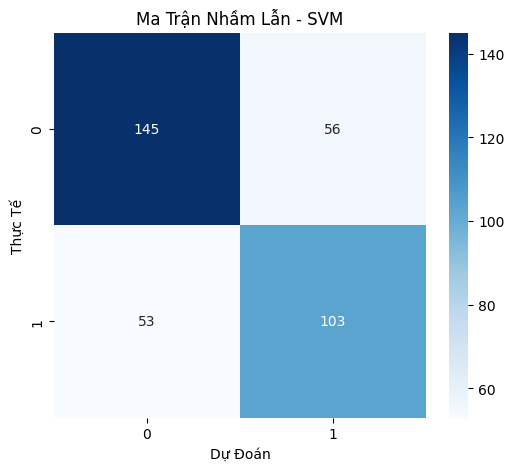

Độ Chính Xác: 0.6947
Precision (binary): 0.6478
Recall (binary): 0.6603
Specificity: 0.7214
F1 Score (binary): 0.6540


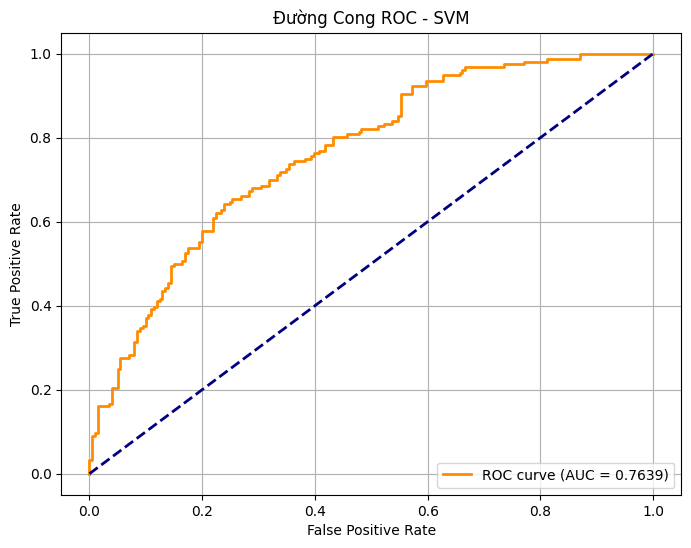

AUC-ROC: 0.7639

Các chỉ số đánh giá cho SVM:
Accuracy: 0.6947
Precision: 0.6478
Recall: 0.6603
Specificity: 0.7214
F1 Score: 0.6540
AUC-ROC: 0.7639


In [137]:
class_labels = [0, 1]  # Phân loại nhị phân
evaluator_svm = ModelEvaluator(class_labels=class_labels, model_name="SVM")

# Đánh giá mô hình với ModelEvaluator
metrics_svm = evaluator_svm.comprehensive_evaluation(
    model=best_svm_model,
    X_test=X_test,
    y_test=y_test,
    average_type='binary'  # Sử dụng 'binary' cho phân loại nhị phân
)

# In kết quả đánh giá
print("\nCác chỉ số đánh giá cho SVM:")
for metric, value in metrics_svm.items():
    print(f"{metric}: {value:.4f}")

#### Đánh giá mô hình XGBoost

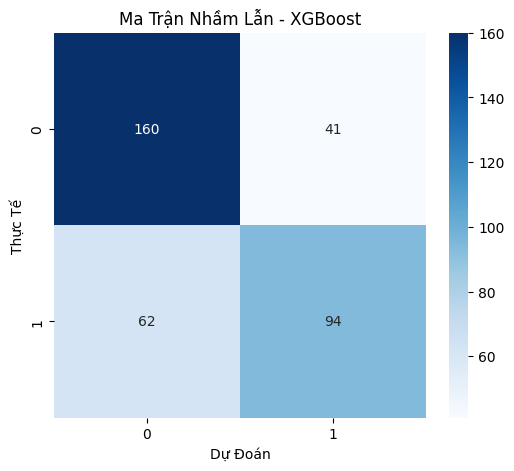

Độ Chính Xác: 0.7115
Precision (binary): 0.6963
Recall (binary): 0.6026
Specificity: 0.7960
F1 Score (binary): 0.6460


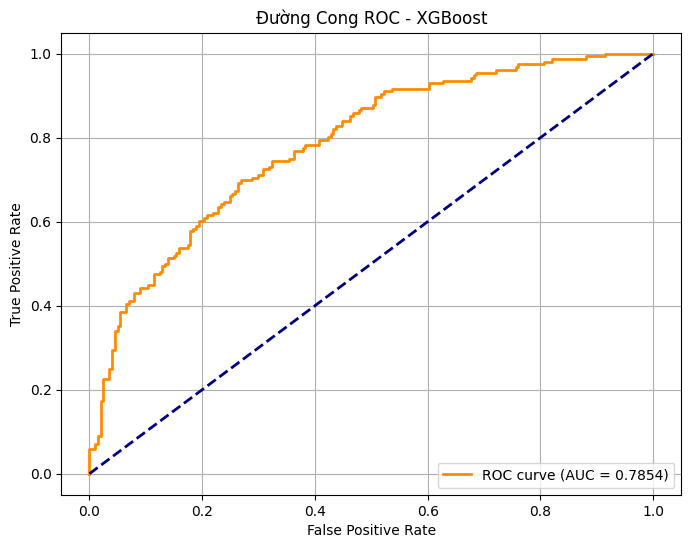

AUC-ROC: 0.7854

Các chỉ số đánh giá cho XGBoost:
Accuracy: 0.7115
Precision: 0.6963
Recall: 0.6026
Specificity: 0.7960
F1 Score: 0.6460
AUC-ROC: 0.7854


In [138]:

evaluator_xgb = ModelEvaluator(class_labels=class_labels, model_name="XGBoost")

# Đánh giá mô hình với ModelEvaluator
metrics_xgb = evaluator_xgb.comprehensive_evaluation(
    model=best_xgb_model,
    X_test=X_test,
    y_test=y_test,
    average_type='binary'  # Sử dụng 'binary' cho phân loại nhị phân
)

# In kết quả đánh giá
print("\nCác chỉ số đánh giá cho XGBoost:")
for metric, value in metrics_xgb.items():
    print(f"{metric}: {value:.4f}")

#### Đánh giá mô hình MLP

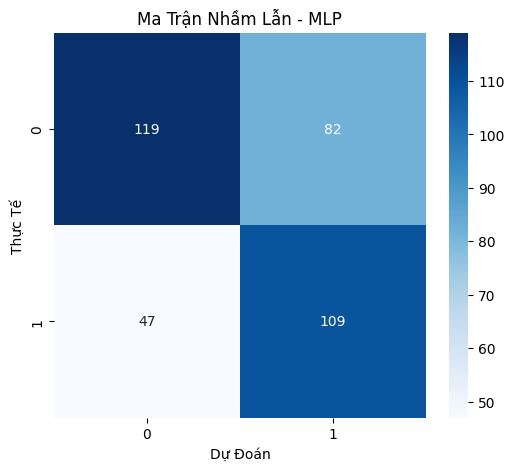

Độ Chính Xác: 0.6387
Precision (binary): 0.5707
Recall (binary): 0.6987
Specificity: 0.5920
F1 Score (binary): 0.6282


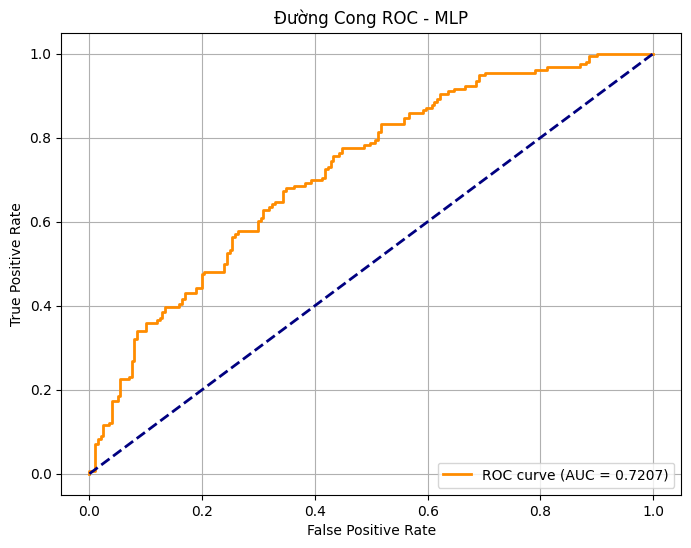

AUC-ROC: 0.7207

Các chỉ số đánh giá cho MLP:
Accuracy: 0.6387
Precision: 0.5707
Recall: 0.6987
Specificity: 0.5920
F1 Score: 0.6282
AUC-ROC: 0.7207


In [139]:
evaluator_mlp = ModelEvaluator(class_labels=class_labels, model_name="MLP")

# Đánh giá mô hình với ModelEvaluator
metrics_mlp = evaluator_mlp.comprehensive_evaluation(
    model=best_mlp,
    X_test=X_test,
    y_test=y_test,
    average_type='binary' 
)

# In kết quả đánh giá
print("\nCác chỉ số đánh giá cho MLP:")
for metric, value in metrics_mlp.items():
    print(f"{metric}: {value:.4f}")

#### Đánh giá mô hình Random Forest

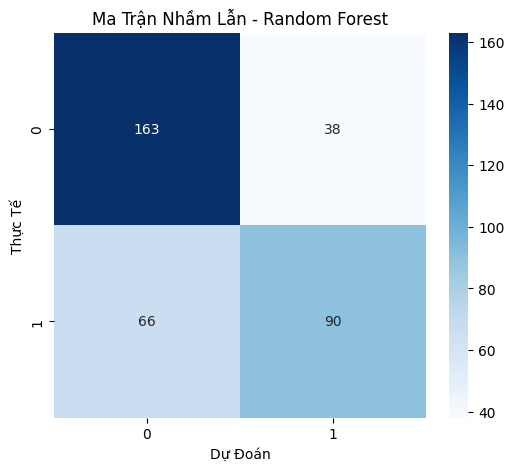

Độ Chính Xác: 0.7087
Precision (binary): 0.7031
Recall (binary): 0.5769
Specificity: 0.8109
F1 Score (binary): 0.6338


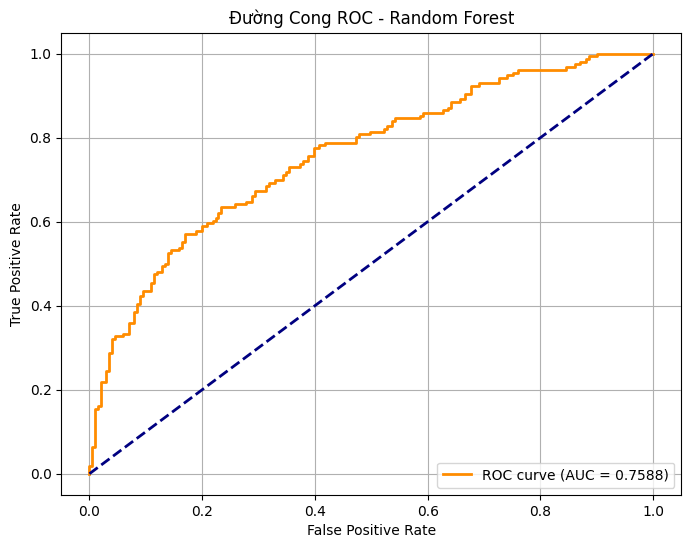

AUC-ROC: 0.7588

Các chỉ số đánh giá cho Random Forest:
Accuracy: 0.7087
Precision: 0.7031
Recall: 0.5769
Specificity: 0.8109
F1 Score: 0.6338
AUC-ROC: 0.7588


In [140]:
evaluator_rf = ModelEvaluator(class_labels=class_labels, model_name="Random Forest")

# Đánh giá mô hình với ModelEvaluator
metrics_rf = evaluator_rf.comprehensive_evaluation(
    model=best_rf_model,
    X_test=X_test,
    y_test=y_test,
    average_type='binary' 
)

# In kết quả đánh giá
print("\nCác chỉ số đánh giá cho Random Forest:")
for metric, value in metrics_rf.items():
    print(f"{metric}: {value:.4f}")